## 期末課題

**Fashion-MNISTで最高正解率を目指す**  
授業で紹介した手法やその発展的手法を利用してFashion-MNISTの対象を判別するモデルを作成し、その手法・正解率・考察をレポートしてください。

### 問題点と解決策
- 学習用データが少ない  
   &rarr; 7,000(講義で使用したデータ数) から 21,000に増やす
- ハイパーパラメータの調節ができていない  
   &rarr; Keras Tunerを使用する

【参考文献】
- [Keras Tunerでハイパーパラメータチューニング | Zenn](https://zenn.dev/monda/articles/hyperparameter-tuning-with-keras-tuner)
- [HyperParameters | Keras](https://keras.io/api/keras_tuner/hyperparameters/)

### ライブラリとダウンロード用の関数の宣言

In [1]:
import os
import cv2
from IPython.display import display, Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import keras_tuner as kt
from kerastuner.tuners import RandomSearch

C:\Users\human\AppData\Local\Temp\ipykernel_26292\506710205.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# 乱数のシードを設定
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# 警告の表示回避
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Fashion-MNISTデータセットのダウンロード (21000枚)
def load_fashion_mnist_data():
    data = fetch_openml('Fashion-MNIST', version=1)
    _x = np.array(data['data'].astype(np.float32))
    _y = np.array(data['target'].astype(np.int32))
    _, x, _, y = train_test_split(_x, _y, test_size=0.3, random_state=42)
    return x, y

### 多層パーセプトロン(Multilayer perceptron; MLP)

入力層，中間層，出力層に層分けされた多層構造のネットワーク  
<img src="https://storage.googleapis.com/zenn-user-upload/45906c06ea3ea859b9a2c4b6.jpg" width="400">

**用語の解説**
- 活性化関数  
    その値を次のニューロンに「どのように出力するか」を決める関数  
    ReLU関数($f(x)=max(0, x)$)がもっとも一般的  
    <img src="https://storage.googleapis.com/zenn-user-upload/ajk9kf54pz7stsq9czkndjb6z86e" width="300"> <img src="https://spjai.com/wp-content/uploads/2017/10/image4-min-3.png" width="230">
- 最適化手法  
    「特定の条件を満たす中から最適な解を選び出す」という問題に対する数学的アプローチの方法  
    以下ではadam(Adaptive moment estimation)により重みの更新を実行する  
    <img src="https://spjai.com/wp-content/uploads/2017/10/image12-min.png" width="300">

【参考】
- [【初心者】ネコでも分かる「活性化関数」ってなに？](https://zenn.dev/nekoallergy/articles/4e224b57a97af9)

#### 第6回課題で使用したMLP

In [5]:
# データを学習用と検証用に分割
x, y = load_fashion_mnist_data()

# 特徴量は 0-1 の範囲に正規化、ターゲットは one-hot ベクトル化
x = x / 255
y = np.identity(10)[y]

# 検証用データに25%を割当て
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

print('## dataset > Fashion-MNIST',
    f'\n## データの分割 > x_train:{len(x_train)} x_test:{len(x_test)} y_train:{len(y_train)} y_test:{len(y_test)}')

## dataset > Fashion-MNIST 
## データの分割 > x_train:15750 x_test:5250 y_train:15750 y_test:5250


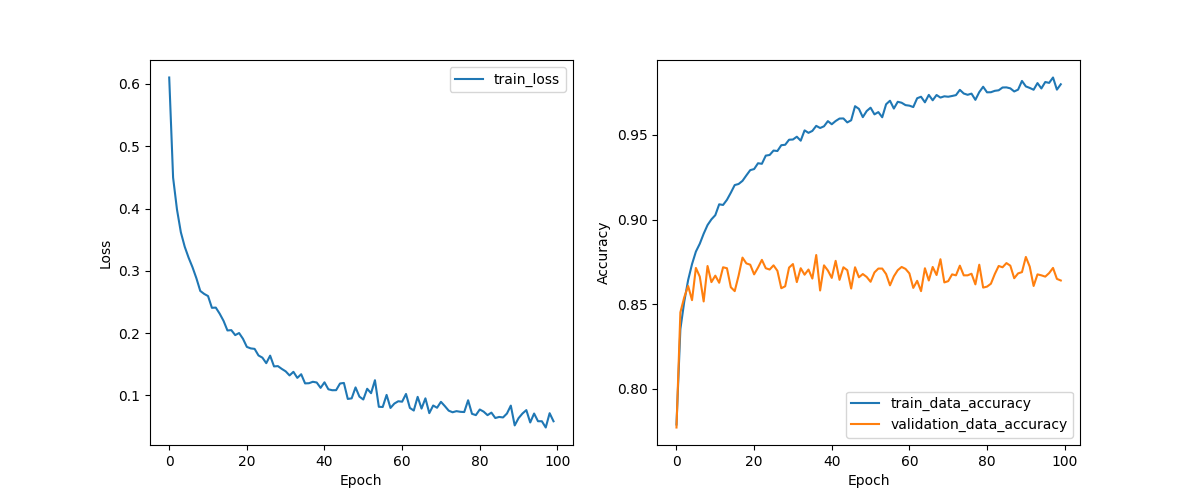

In [6]:
ismodel = os.path.isfile('model/rnn_model_1.h5')

# 学習済みモデルがないとき
if not ismodel:
    # ニューラルネットワークのモデルを作成
    rnn_model_1 = tf.keras.models.Sequential(name='mnist_model')    # ニューラルネットワークモデル
    rnn_model_1.add(tf.keras.Input(shape=(784,), name='Input'))     # 784入力の入力層
    rnn_model_1.add(tf.keras.layers.Dense(units=784, activation='relu', name='Dense_1'))    # 全結合層 (活性化関数: ReLU)
    rnn_model_1.add(tf.keras.layers.Dense(units=784, activation='relu', name='Dense_2'))    # 全結合層 (活性化関数: ReLU)
    rnn_model_1.add(tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))   # 全結合層 (活性化関数: softmax)

    # 学習時の設定を行い，学習を実施
    rnn_model_1.compile(
        loss='categorical_crossentropy',    # 損失関数
        optimizer='adam',                   # 最適化関数
        metrics=['accuracy']                # 評価関数
    )
    history = rnn_model_1.fit(
        x_train, y_train,   # 学習用データ
        epochs=100,         # epoch数
        batch_size=10,      # バッチサイズ
        verbose=0,          # 出力調整
        validation_data=(x_test, y_test)    # validation用のデータを設定
    )

    # 学習中の精度の変化をグラフで表示
    fig, ax = plt.subplots(1, 1, figsize=(12,5))
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    # 学習中のlossの変化をグラフで表示
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].legend(loc='upper right')

    # 学習中の学習用データに対する正解率の変化をグラフで表示
    ax[1].plot(history.history['accuracy'], label='train_data_accuracy')

    # 学習中の検証用データに対する正解率の変化をグラフで表示
    ax[1].plot(history.history['val_accuracy'], label='validation_data_accuracy')

    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='lower right')
    plt.savefig('fig/loss_accuracy/rnn_model_1.png')
    plt.show()

    rnn_model_1.save('model/rnn_model_1.h5')

# 学習済みモデルがあるとき
else:
    rnn_model_1 = tf.keras.models.load_model('model/rnn_model_1.h5')

    # 学習中の精度の変化をグラフで表示
    img = cv2.imread('fig/loss_accuracy/rnn_model_1.png')
    _, buf = cv2.imencode('.png', img)
    display(Image(data=buf.tobytes()))

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 784)               615440    
                                                                 
 Dense_2 (Dense)             (None, 784)               615440    
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 1238730 (4.73 MB)
Trainable params: 1238730 (4.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


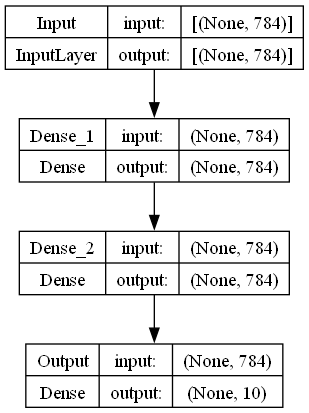

In [7]:
# モデルの概要
rnn_model_1.summary()
tf.keras.utils.plot_model(
    rnn_model_1,
    show_shapes=True,
    to_file='fig/plot_model/rnn_model_1.png'
)

In [8]:
# 学習したモデルで検証用データの数字を予測し、数字ごとに結果を表示
pred_test = rnn_model_1.predict(x_test)
for i in range(10):
    print(
        f'y_test[{i}] {y_test[i]} -> pred_test[{i}] ',
        f'[{pred_test[i][0]:.5f}, {pred_test[i][1]:.5f}, {pred_test[i][2]:.5f}, ',
        f'{pred_test[i][3]:.5f}, {pred_test[i][4]:.5f}, {pred_test[i][5]:.5f}, ',
        f'{pred_test[i][6]:.5f}, {pred_test[i][7]:.5f}, {pred_test[i][8]:.5f}, {pred_test[i][9]:.5f}]'
    )

# 学習したモデルの性能(正答率)を学習用データと検証用データで評価
train_loss, train_accuracy = rnn_model_1.evaluate(x_train, y_train, batch_size=128, verbose=0)
test_loss, test_accuracy = rnn_model_1.evaluate(x_test, y_test, batch_size=128, verbose=0)

print('[model:CNN]\t',
    f' accuracy_score: (train){train_accuracy: .5f}\t',
    f'(test){test_accuracy: .5f}')

165/165 [==============================] - 0s 1ms/step
y_test[0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[0]  [0.92031, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000,  0.07969, 0.00000, 0.00000, 0.00000]
y_test[1] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> pred_test[1]  [0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000,  0.00000, 1.00000, 0.00000, 0.00000]
y_test[2] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> pred_test[2]  [0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000,  0.00000, 1.00000, 0.00000, 0.00000]
y_test[3] [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] -> pred_test[3]  [0.00000, 0.00000, 0.00000,  1.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[4] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] -> pred_test[4]  [0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 1.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[5] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[5]  [0.00000, 0.00000, 0.95589,  0.00000, 0.04411, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[6] [0. 0. 0. 0. 0. 0. 0. 0

#### Keras Tuner

In [9]:
# データを学習用と検証用に分割
x, y = load_fashion_mnist_data()

# 特徴量は 0-1 の範囲に正規化、ターゲットは one-hot ベクトル化
x = x / 255
y = np.identity(10)[y]

# 検証用データに25%を割当て
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

print('## dataset > Fashion-MNIST',
    f'\n## データの分割 > x_train:{len(x_train)} x_test:{len(x_test)} y_train:{len(y_train)} y_test:{len(y_test)}')

## dataset > Fashion-MNIST 
## データの分割 > x_train:15750 x_test:5250 y_train:15750 y_test:5250


In [10]:
def build_rnn_model(hp):
    model = tf.keras.Sequential(name='mnist_model')

    model.add(tf.keras.Input(shape=(784,), name='Input'))     # 784入力の入力層

    # 層の数(2~20)
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(           # ユニットの数 (32~512の32ごと値)
                'units_' + str(i),
                min_value=32,
                max_value=512,
                step=32
            ),
            activation='relu'
        ))

        # BatchNormalization or Dropout or どちらもか
        if hp.Choice('batchnorm_and_dropout', ['batch', 'dropout', 'both']) == 'batch':
            model.add(tf.keras.layers.BatchNormalization())
        elif hp.Choice('batchnorm_and_dropout', ['batch', 'dropout', 'both']) == 'dropout':
            model.add(tf.keras.layers.Dropout(0.2))
        else:
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.2))

    # 出力層
    model.add(tf.keras.layers.Dense(
        10,
        activation='softmax',
        name='Output'
    ))

    # モデルのコンパイル
    model.compile(
        optimizer=tf.keras.optimizers.Adam( # 最適化関数
            # 学習率 (1e-2, 1e-3, 1e-4)
            hp.Choice(
                'learning_rate',
                [1e-2, 1e-3, 1e-4]
            )),
        loss='categorical_crossentropy',    # 損失関数
        metrics=['accuracy']                # 評価関数
    )

    return model

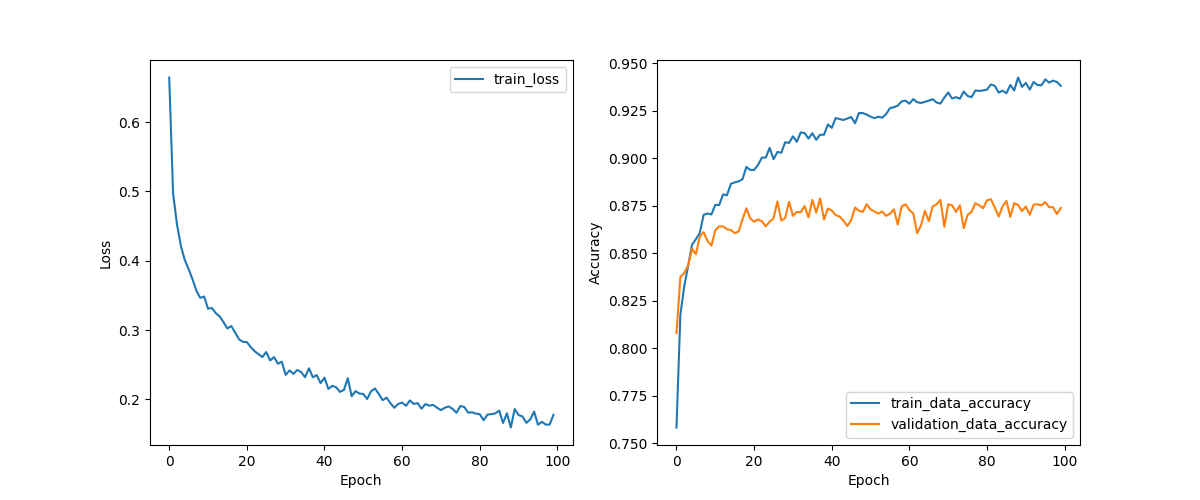

In [11]:
ismodel = os.path.isfile('model/rnn_model_2.h5')

# 学習済みモデルがないとき
if not ismodel:
    # チューナーのインスタンス化
    tuner = RandomSearch(
        hypermodel=build_rnn_model,
        objective='val_accuracy',
        max_trials=100,
        seed=42,
        directory='tuner_dir',
        project_name='MLP',
        overwrite=True
    )

    # ハイパーパラメータの探索
    tuner.search(
        x_train, y_train,   # 学習用データ
        epochs=100,         # epoch数
        verbose=2,          # 出力調整
        validation_data=(x_test, y_test)    # validation用のデータを設定
    )

    # 最も性能が良かったハイパーパラメータを使ってモデルをビルドする
    best_hp = tuner.get_best_hyperparameters()[0]
    print(best_hp.values)
    rnn_model_2 = tuner.hypermodel.build(best_hp)

    # モデルの学習
    history = rnn_model_2.fit(
        x_train, y_train,   # 学習用データ
        epochs=100,         # epoch数
        batch_size=10,      # バッチサイズ
        verbose=0,          # 出力調整
        validation_data=(x_test, y_test)    # validation用のデータを設定
    )

    # 学習中の精度の変化をグラフで表示
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    # 学習中のlossの変化をグラフで表示
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].legend(loc='upper right')

    # 学習中の学習用データに対する正解率の変化をグラフで表示
    ax[1].plot(history.history['accuracy'], label='train_data_accuracy')

    # 学習中の検証用データに対する正解率の変化をグラフで表示
    ax[1].plot(history.history['val_accuracy'], label='validation_data_accuracy')

    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='lower right')
    plt.savefig('fig/loss_accuracy/rnn_model_2.png')
    plt.show()

    rnn_model_2.save('model/rnn_model_2.h5')

# 学習済みモデルがあるとき
else:
    rnn_model_2 = tf.keras.models.load_model('model/rnn_model_2.h5')

    # 学習中の精度の変化をグラフで表示
    img = cv2.imread('fig/loss_accuracy/rnn_model_2.png')
    _, buf = cv2.imencode('.png', img)
    display(Image(data=buf.tobytes()))

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 416)               326560    
                                                                 
 dropout (Dropout)           (None, 416)               0         
                                                                 
 dense_8 (Dense)             (None, 384)               160128    
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 Output (Dense)              (None, 10)                3850      
                                                                 
Total params: 490538 (1.87 MB)
Trainable params: 490538 (1.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


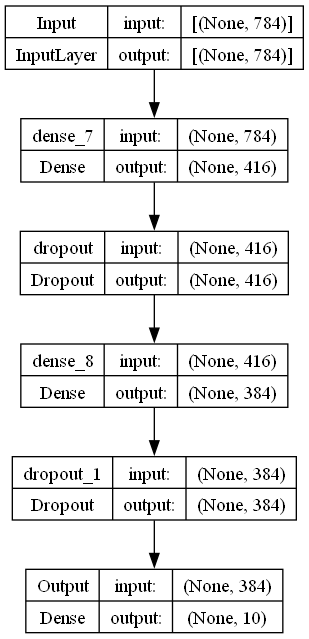

In [12]:
# モデルの概要
rnn_model_2.summary()
tf.keras.utils.plot_model(
    rnn_model_2,
    show_shapes=True,
    to_file='fig/plot_model/rnn_model_2.png'
)

In [13]:
# 学習したモデルで検証用データの数字を予測し、数字ごとに結果を表示
pred_test = rnn_model_2.predict(x_test)
for i in range(10):
    print(
        f'y_test[{i}] {y_test[i]} -> pred_test[{i}] ',
        f'[{pred_test[i][0]:.5f}, {pred_test[i][1]:.5f}, {pred_test[i][2]:.5f}, ',
        f'{pred_test[i][3]:.5f}, {pred_test[i][4]:.5f}, {pred_test[i][5]:.5f}, ',
        f'{pred_test[i][6]:.5f}, {pred_test[i][7]:.5f}, {pred_test[i][8]:.5f}, {pred_test[i][9]:.5f}]'
    )

# 学習したモデルの性能(正答率)を学習用データと検証用データで評価
train_loss, train_accuracy = rnn_model_2.evaluate(x_train, y_train, batch_size=128, verbose=0)
test_loss, test_accuracy = rnn_model_2.evaluate(x_test, y_test, batch_size=128, verbose=0)

print('[model:CNN]\t',
    f' accuracy_score: (train){train_accuracy: .5f}\t',
    f'(test){test_accuracy: .5f}')

165/165 [==============================] - 0s 889us/step
y_test[0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[0]  [0.78547, 0.00000, 0.00002,  0.00651, 0.00000, 0.00000,  0.20800, 0.00000, 0.00000, 0.00000]
y_test[1] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> pred_test[1]  [0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00005,  0.00000, 0.99937, 0.00000, 0.00058]
y_test[2] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> pred_test[2]  [0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000,  0.00000, 1.00000, 0.00000, 0.00000]
y_test[3] [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] -> pred_test[3]  [0.00330, 0.00509, 0.00001,  0.99156, 0.00000, 0.00000,  0.00005, 0.00000, 0.00000, 0.00000]
y_test[4] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] -> pred_test[4]  [0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 1.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[5] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[5]  [0.00000, 0.00000, 0.99140,  0.00000, 0.00815, 0.00000,  0.00045, 0.00000, 0.00000, 0.00000]
y_test[6] [0. 0. 0. 0. 0. 0. 0.

### CNN

入力層，出力層，その間にある多くの隠れ層で構成される，主に画像認識の分野で用いられるディープラーニングアルゴリズム  
<img src="https://jp.mathworks.com/discovery/convolutional-neural-network-matlab/_jcr_content/mainParsys/band_copy_copy/mainParsys/lockedsubnav/mainParsys/columns/a32c7d5d-8012-4de1-bc76-8bd092f97db8/image_792810770_copy.adapt.full.medium.jpg/1678866562130.jpg" width="400">  
<img src="https://jp.mathworks.com/discovery/convolutional-neural-network-matlab/_jcr_content/mainParsys/band_copy_copy/mainParsys/lockedsubnav/mainParsys/columns/a32c7d5d-8012-4de1-bc76-8bd092f97db8/image_2109075398_cop.adapt.full.medium.jpg/1678866562161.jpg" width="600">

**用語の解説**
- 畳み込み層  
    入力画像を一連の畳み込みフィルターに通すことで，重み行列に変換して特徴を活性化する層  
    以下のプログラムでは2次元畳み込み層(`layers.Conv2D`)を実装している  
    <img src="https://www.imagazine.co.jp/wp-content/uploads/2018/07/086-090_16ISno13_kiso_deep_zu003-1024x613.jpg" width="300"> <img src="https://www.imagazine.co.jp/wp-content/uploads/2018/07/086-090_16ISno13_kiso_deep_zu004-1024x734.jpg" width="300">
- プーリング層  
    出力を単純化し，ネットワークが学習する必要のあるパラメーターの数を減らす層  
    <img src="https://www.imagazine.co.jp/wp-content/uploads/2018/07/086-090_16ISno13_kiso_deep_zu006-1024x563.jpg" width="300"> <img src="https://www.imagazine.co.jp/wp-content/uploads/2018/07/086-090_16ISno13_kiso_deep_zu007-1024x440.jpg" width="300">
- 平坦化層  
    プーリング層の出力データを1次元化する層
- 全結合層  
    これまでの層によって抽出した特徴量を強調する層

【参考】
- [機械学習初学者のKerasでCNN #機械学習](https://qiita.com/mako0715/items/b6605a77467ac439955b)
- [畳み込みニューラルネットワーク(CNN)をわかりやすく基本から実装まで解説](https://zero2one.jp/learningblog/cnn-for-beginners/)
- [畳み込みニューラル ネットワークとは | これだけは知っておきたい 3 つのこと](https://jp.mathworks.com/discovery/convolutional-neural-network-matlab.html)
- [畳み込みネットワークの「基礎の基礎」を理解する　～ディープラーニング入門｜第2回](https://www.imagazine.co.jp/%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%AE%E3%80%8C%E5%9F%BA%E7%A4%8E%E3%81%AE%E5%9F%BA%E7%A4%8E%E3%80%8D%E3%82%92%E7%90%86%E8%A7%A3%E3%81%99/)

#### 第6回課題で使用したCNN

In [14]:
# データを学習用と検証用に分割
x, y = load_fashion_mnist_data()

# 検証用データに25%を割当て
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

print('## dataset > Fashion-MNIST',
    f'\n## データの分割 > x_train:{len(x_train)} x_test:{len(x_test)} y_train:{len(y_train)} y_test:{len(y_test)}')

# 標準化
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# データの前処理
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## dataset > Fashion-MNIST 
## データの分割 > x_train:15750 x_test:5250 y_train:15750 y_test:5250


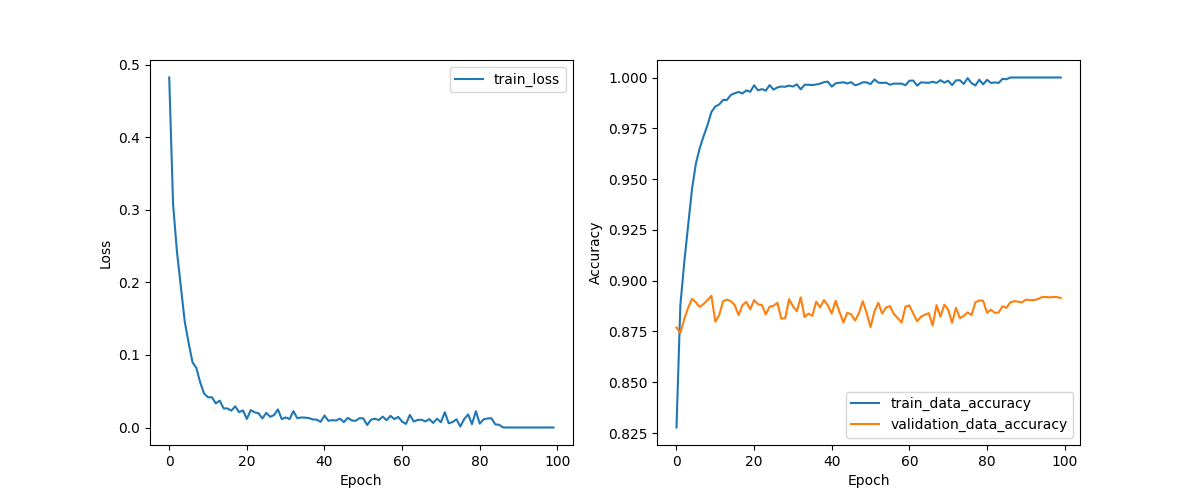

In [15]:
ismodel = os.path.isfile('model/cnn_model_1.h5')

# 学習済みモデルがないとき
if not ismodel:
    # CNNモデルの構築
    cnn_model_1 = tf.keras.models.Sequential(name='mnist_model')
    cnn_model_1.add(tf.keras.layers.Conv2D( # 畳み込み層
        32,                                 # フィルタ数
        kernel_size=(3, 3),                 # カーネルサイズ
        activation='relu',                  # 活性化関数(ReLU関数)
        input_shape=(28, 28, 1),            # 入力の形状(MNIST:28[px](縦) x 28[px](横) x 1(グレースケール))
        name='Conv2D'
    ))
    cnn_model_1.add(tf.keras.layers.MaxPooling2D(   # プーリング層(最大値を採用してプーリング)
        pool_size=(2, 2),
        name='MaxPooling2D')
    )
    cnn_model_1.add(tf.keras.layers.Flatten(name='Flatten'))    # 1次元配列化
    cnn_model_1.add(tf.keras.layers.Dense(  # 全結合層(128個のノード設置，活性化関数:ReLU)
        128,
        activation='relu',
        name='Dense_1'
    ))
    cnn_model_1.add(tf.keras.layers.Dense(  # 出力層(数字の個数分の10個のノード設置，活性化関数:softmax)
        10,
        activation='softmax',
        name='Dense_2'
    ))

    # モデルのコンパイル
    cnn_model_1.compile(
        loss='categorical_crossentropy',    # 損失関数(ラベルデータと出力の誤差計算の関数)
        optimizer='adam',                   # 最適化手法
        metrics=['accuracy']                # 正解率で評価
    )

    # モデルの学習
    history = cnn_model_1.fit(
        x_train, y_train,   # 学習用データ
        epochs=100,         # epoch数
        batch_size=10,      # バッチサイズ
        verbose=0,          # 出力調整
        validation_data=(x_test, y_test)    # validation用のデータを設定
    )

    # 学習中の精度の変化をグラフで表示
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    # 学習中のlossの変化をグラフで表示
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].legend(loc='upper right')

    # 学習中の学習用データに対する正解率の変化をグラフで表示
    ax[1].plot(history.history['accuracy'], label='train_data_accuracy')

    # 学習中の検証用データに対する正解率の変化をグラフで表示
    ax[1].plot(history.history['val_accuracy'], label='validation_data_accuracy')

    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='lower right')
    plt.savefig('fig/loss_accuracy/cnn_model_1.png')
    plt.show()

    cnn_model_1.save('model/cnn_model_1.h5')

# 学習済みモデルがあるとき
else:
    cnn_model_1 = tf.keras.models.load_model('model/cnn_model_1.h5')

    # 学習中の精度の変化をグラフで表示
    img = cv2.imread('fig/loss_accuracy/cnn_model_1.png')
    _, buf = cv2.imencode('.png', img)
    display(Image(data=buf.tobytes()))

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 MaxPooling2D (MaxPooling2D  (None, 13, 13, 32)        0         
 )                                                               
                                                                 
 Flatten (Flatten)           (None, 5408)              0         
                                                                 
 Dense_1 (Dense)             (None, 128)               692352    
                                                                 
 Dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693962 (2.65 MB)
Trainable params: 693962 (2.65 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

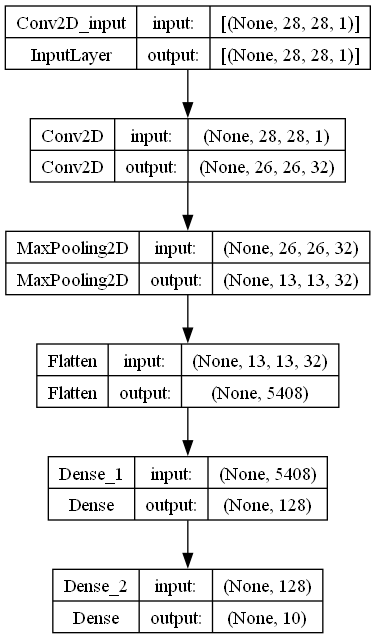

In [16]:
# モデルの概要
cnn_model_1.summary()
tf.keras.utils.plot_model(
    cnn_model_1,
    show_shapes=True,
    to_file='fig/plot_model/cnn_model_1.png'
)

In [17]:
# 学習したモデルで検証用データの数字を予測し、数字ごとに結果を表示
pred_test = cnn_model_1.predict(x_test)
for i in range(10):
    print(
        f'y_test[{i}] {y_test[i]} -> pred_test[{i}] ',
        f'[{pred_test[i][0]:.5f}, {pred_test[i][1]:.5f}, {pred_test[i][2]:.5f}, ',
        f'{pred_test[i][3]:.5f}, {pred_test[i][4]:.5f}, {pred_test[i][5]:.5f}, ',
        f'{pred_test[i][6]:.5f}, {pred_test[i][7]:.5f}, {pred_test[i][8]:.5f}, {pred_test[i][9]:.5f}]'
    )

# 学習したモデルの性能(正答率)を学習用データと検証用データで評価
train_loss, train_accuracy = cnn_model_1.evaluate(x_train, y_train, batch_size=128, verbose=0)
test_loss, test_accuracy = cnn_model_1.evaluate(x_test, y_test, batch_size=128, verbose=0)

print('[model:CNN]\t',
    f' accuracy_score: (train){train_accuracy: .5f}\t',
    f'(test){test_accuracy: .5f}')

  1/165 [..............................] - ETA: 6s

165/165 [==============================] - 0s 1ms/step
y_test[0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[0]  [0.00000, 1.00000, 0.00000,  0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[1] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[1]  [0.00000, 0.00000, 1.00000,  0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[2] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] -> pred_test[2]  [0.00000, 0.00000, 0.00000,  0.00000, 1.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[3] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[3]  [0.00000, 0.00000, 1.00000,  0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[4] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[4]  [1.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[5] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] -> pred_test[5]  [0.00000, 0.00000, 0.00000,  0.00000, 1.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[6] [1. 0. 0. 0. 0. 0. 0. 0

#### Keras Tuner

In [18]:
# データを学習用と検証用に分割
x, y = load_fashion_mnist_data()

# 検証用データに25%を割当て
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

print('## dataset > Fashion-MNIST',
    f'\n## データの分割 > x_train:{len(x_train)} x_test:{len(x_test)} y_train:{len(y_train)} y_test:{len(y_test)}')

# 標準化
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# データの前処理
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## dataset > Fashion-MNIST 
## データの分割 > x_train:15750 x_test:5250 y_train:15750 y_test:5250


In [19]:
def build_cnn_model(hp):
    model = tf.keras.Sequential(name='mnist_model')

    # 層の構成
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int(     # フィルタの数 (32~512の32ごと値)
            'conv_1_filter',
            min_value=32,
            max_value=512,
            step=32
        ),
        kernel_size=hp.Choice(
            'conv_1_kernel',
            values = [3, 5]
        ),
        activation='relu',
        input_shape=(28,28,1)
    ))
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int(     # フィルタの数 (32~64の16ごと値)
            'conv_2_filter',
            min_value=32,
            max_value=64,
            step=16
        ),
        kernel_size=hp.Choice(
            'conv_2_kernel',
            values = [3, 5]
        ),
        activation='relu',
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int(       # フィルタの数 (32~512の32ごと値)
            'units',
            min_value=32,
            max_value=512,
            step=32),
        activation='relu'
    ))

    # 出力層
    model.add(tf.keras.layers.Dense(
        10,
        activation='softmax',
        name='Output'
    ))

    # モデルのコンパイル
    model.compile(
        optimizer=tf.keras.optimizers.Adam( # 最適化関数
            # 学習率 (1e-2, 1e-3, 1e-4)
            hp.Choice(
                'learning_rate',
                [1e-2, 1e-3, 1e-4]
            )),
        loss='categorical_crossentropy',    # 損失関数
        metrics=['accuracy']                # 評価関数
    )

    return model

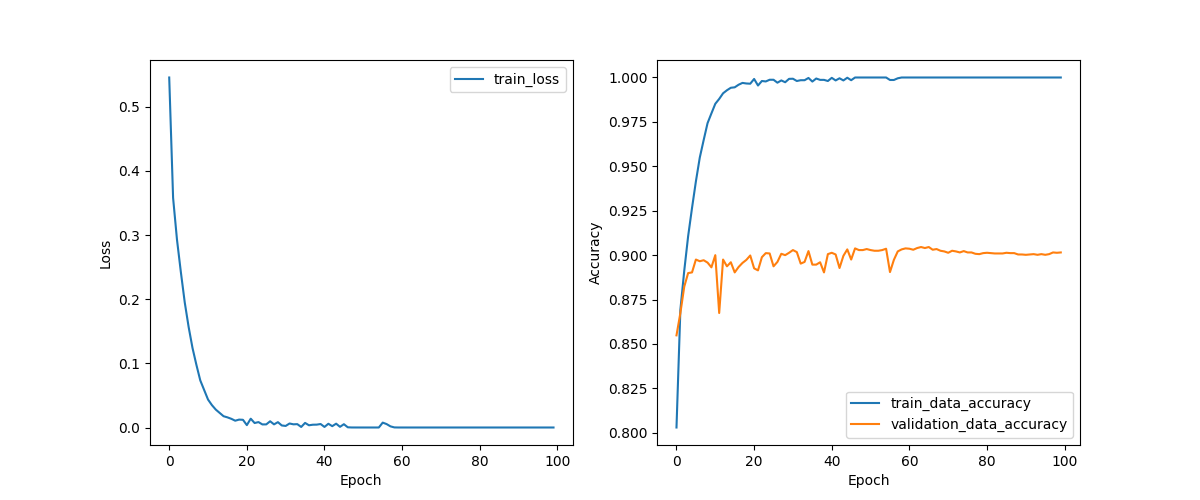

In [20]:
ismodel = os.path.isfile('model/cnn_model_2.h5')

# 学習済みモデルがないとき
if not ismodel:
    # チューナーのインスタンス化
    tuner = RandomSearch(
        hypermodel=build_cnn_model,
        objective='val_accuracy',
        max_trials=100,
        seed=42,
        directory='tuner_dir',
        project_name='CNN',
        overwrite=True
    )

    # ハイパーパラメータの探索
    tuner.search(
        x_train, y_train,   # 学習用データ
        epochs=100,         # epoch数
        verbose=2,          # 出力調整
        validation_data=(x_test, y_test)    # validation用のデータを設定
    )

    # 最も性能が良かったハイパーパラメータを使ってモデルをビルドする
    best_hp = tuner.get_best_hyperparameters()[0]
    print(best_hp.values)
    cnn_model_2 = tuner.hypermodel.build(best_hp)

    # モデルの学習
    history = cnn_model_2.fit(
        x_train, y_train,   # 学習用データ
        epochs=100,         # epoch数
        batch_size=10,      # バッチサイズ
        verbose=0,          # 出力調整
        validation_data=(x_test, y_test)    # validation用のデータを設定
    )

    # 学習中の精度の変化をグラフで表示
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    # 学習中のlossの変化をグラフで表示
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].legend(loc='upper right')

    # 学習中の学習用データに対する正解率の変化をグラフで表示
    ax[1].plot(history.history['accuracy'], label='train_data_accuracy')

    # 学習中の検証用データに対する正解率の変化をグラフで表示
    ax[1].plot(history.history['val_accuracy'], label='validation_data_accuracy')

    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='lower right')
    plt.savefig('fig/loss_accuracy/cnn_model_2.png')
    plt.show()

    cnn_model_2.save('model/cnn_model_2.h5')

# 学習済みモデルがあるとき
else:
    cnn_model_2 = tf.keras.models.load_model('model/cnn_model_2.h5')

    # 学習中の精度の変化をグラフで表示
    img = cv2.imread('fig/loss_accuracy/cnn_model_2.png')
    _, buf = cv2.imencode('.png', img)
    display(Image(data=buf.tobytes()))

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 48)        153648    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 48)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 5808)              0         
                                                                 
 dense_1 (Dense)             (None, 288)               1672992   
                                                                 
 Output (Dense)              (None, 10)                2890      
                                                       

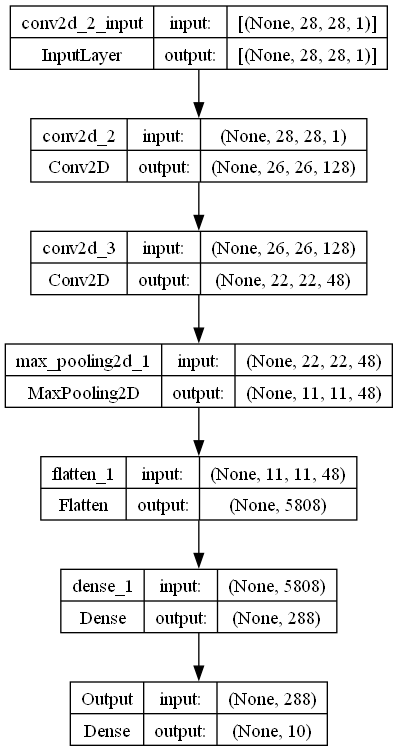

In [21]:
# モデルの概要
cnn_model_2.summary()
tf.keras.utils.plot_model(
    cnn_model_2,
    show_shapes=True,
    to_file='fig/plot_model/cnn_model_2.png'
)

In [22]:
# 学習したモデルで検証用データの数字を予測し、数字ごとに結果を表示
pred_test = cnn_model_2.predict(x_test)
for i in range(10):
    print(
        f'y_test[{i}] {y_test[i]} -> pred_test[{i}] ',
        f'[{pred_test[i][0]:.5f}, {pred_test[i][1]:.5f}, {pred_test[i][2]:.5f}, ',
        f'{pred_test[i][3]:.5f}, {pred_test[i][4]:.5f}, {pred_test[i][5]:.5f}, ',
        f'{pred_test[i][6]:.5f}, {pred_test[i][7]:.5f}, {pred_test[i][8]:.5f}, {pred_test[i][9]:.5f}]'
    )

# 学習したモデルの性能(正答率)を学習用データと検証用データで評価
train_loss, train_accuracy = cnn_model_2.evaluate(x_train, y_train, batch_size=128, verbose=0)
test_loss, test_accuracy = cnn_model_2.evaluate(x_test, y_test, batch_size=128, verbose=0)

print('[model:CNN]\t',
    f' accuracy_score: (train){train_accuracy: .5f}\t',
    f'(test){test_accuracy: .5f}')

  1/165 [..............................] - ETA: 7s

165/165 [==============================] - 1s 7ms/step
y_test[0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[0]  [0.00000, 1.00000, 0.00000,  0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[1] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[1]  [0.00000, 0.00000, 1.00000,  0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[2] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] -> pred_test[2]  [0.00000, 0.00000, 0.00000,  0.00000, 1.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[3] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[3]  [0.00000, 0.00000, 1.00000,  0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[4] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[4]  [1.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[5] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] -> pred_test[5]  [0.00000, 0.00000, 0.00000,  0.00000, 1.00000, 0.00000,  0.00000, 0.00000, 0.00000, 0.00000]
y_test[6] [1. 0. 0. 0. 0. 0. 0. 0